# Twitter Sentiment Analysis

### **Import Library**

In [1]:
!pip install jcopml

     |████████████████████████████████| 81kB 3.3MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33231 sha256=a70371221459ce68a6f4995c7afdeb6ba82a3b7ec5eabb26a25774e9d292d159
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built jcopml


In [2]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Import Dataset**

In [3]:
tweet = pd.read_csv(r'Tweets.csv')
tweet.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


### Data Exploration

In [4]:
from jcopml.plot import plot_missing_value

,missing_value,%
tweet_id,0,0.00
airline_sentiment,0,0.00
airline_sentiment_confidence,0,0.00
negativereason,5462,37.31
negativereason_confidence,4118,28.13
airline,0,0.00
airline_sentiment_gold,14600,99.73
name,0,0.00
negativereason_gold,14608,99.78
retweet_count,0,0.00


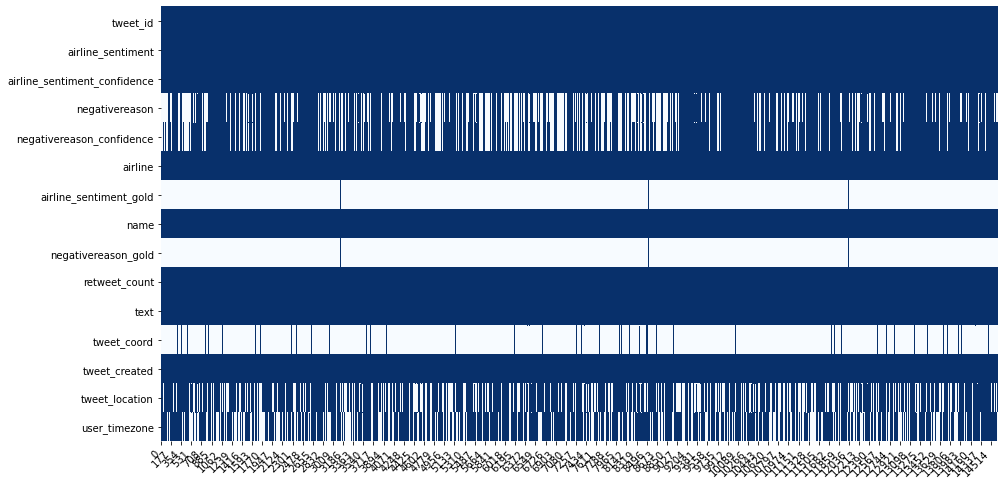

In [5]:
plot_missing_value(tweet, return_df=True)

Dapat dilihat bahwa missing values pada kolom 'airline_sentiment_gold', 'negativereason_gold', dan 'tweet_coord' sangat banyak bahkan mencapai lebih dari 90% sehingga kita bisa menghapus kolom-kolom tersebut

Sementara untuk missing values pada negativereason, negativereason_confidence, tweet_location, dan user_timezone jumlahnya tidak terlalu banyak, masih sekitar 30%, kita bisa abaikan saja atau kita drop missing valuesnya, untuk kali ini akan saya abaikan

In [6]:
del tweet['airline_sentiment_gold']
del tweet['negativereason_gold']
del tweet['tweet_coord']

In [7]:
tweet.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64

Kita telah drop missing valuesnya pada kolom yang memiliki missing values diatas 50%

#### **Menghitung Jumlah Sentiment (Moods)**

In [8]:
moods = tweet['airline_sentiment'].value_counts()
moods

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

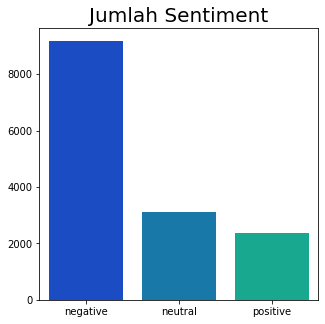

In [9]:
plt.figure(figsize=(5, 5))
sns.barplot(x=moods[:].index, y=moods[:].values, palette='winter')
plt.title('Jumlah Sentiment', fontsize=20)
plt.show()

Dataset didominasi oleh sentiment negatif

#### Menghitung jumlah sentiment berdasarkan maskapai penerbangan

In [10]:
tweet['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

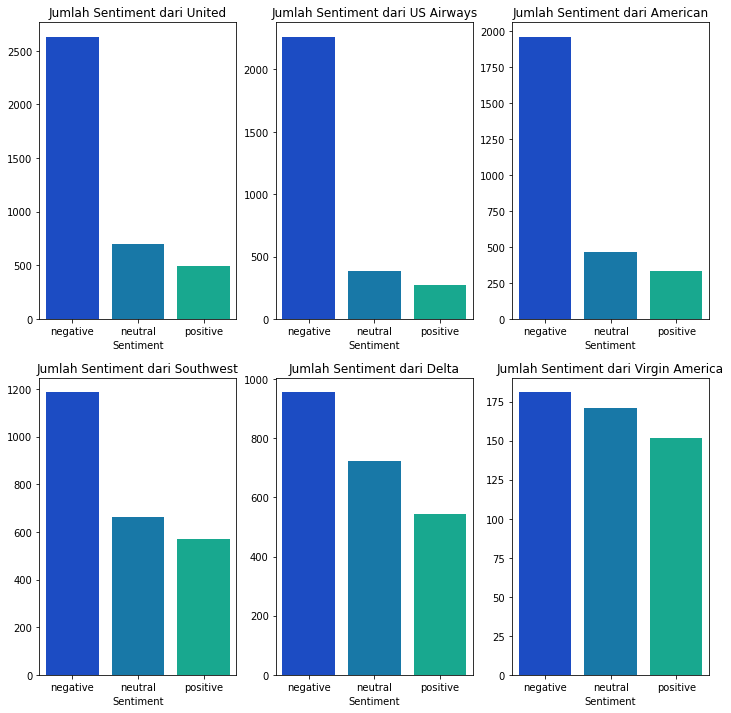

In [11]:
def plot_sentiment_airline(Airline):
  df = tweet[tweet['airline'] == Airline]
  hitung = df['airline_sentiment'].value_counts()
  sns.barplot(x=hitung[:].index, y=hitung[:].values, palette='winter')
  plt.xlabel('Sentiment')
  plt.title('Jumlah Sentiment dari ' + Airline)
plt.figure(1, figsize=(12, 12))
plt.subplot(231)
plot_sentiment_airline('United')
plt.subplot(232)
plot_sentiment_airline('US Airways')
plt.subplot(233)
plot_sentiment_airline('American')
plt.subplot(234)
plot_sentiment_airline('Southwest')
plt.subplot(235)
plot_sentiment_airline('Delta')
plt.subplot(236)
plot_sentiment_airline('Virgin America')

Dapat dilihat pada tiga maskapai pertama bahwa sentiment sangat didominasi dengan sentimen negatif sementara pada tiga maskapai terakhir sentiment negatif masih banyak namun lebih terdistribusi secara merata

In [12]:
sentiment_negatif = dict(tweet['negativereason'].value_counts(sort=False))
sentiment_negatif

{'Bad Flight': 580,
 "Can't Tell": 1190,
 'Cancelled Flight': 847,
 'Customer Service Issue': 2910,
 'Damaged Luggage': 74,
 'Flight Attendant Complaints': 481,
 'Flight Booking Problems': 529,
 'Late Flight': 1665,
 'Lost Luggage': 724,
 'longlines': 178}

In [13]:
def sentiment_negatif(Airline):
  if Airline == 'All':
    df = tweet
  else :
    df = tweet[tweet['airline'] == Airline]
  hitung = dict(df['negativereason'].value_counts())
  Unique_reason = list(tweet['negativereason'].unique())
  Unique_reason = [x for x in Unique_reason if str(x) != 'nan']
  reason_dataframe = pd.DataFrame({'Reasons' : Unique_reason})
  reason_dataframe['count'] = reason_dataframe['Reasons'].apply(lambda x: hitung[x])
  return reason_dataframe

In [14]:
def plot_reason(Airline):
  df = sentiment_negatif(Airline)
  hitung = df['count']
  Index = range(1, (len(df) + 1))
  plt.bar(Index, hitung, color=['red'])
  plt.xticks(Index, df['Reasons'], rotation=90)
  plt.xlabel('Reasons')
  plt.title('Jumlah Alasan berdasarkan Maskapai ' + Airline)

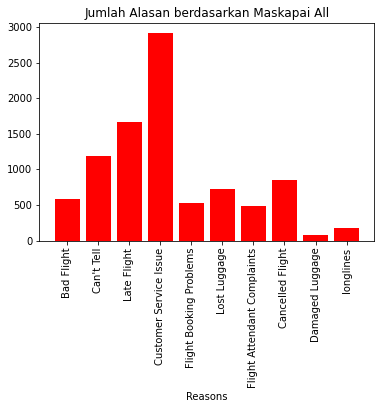

In [15]:
plot_reason('All')

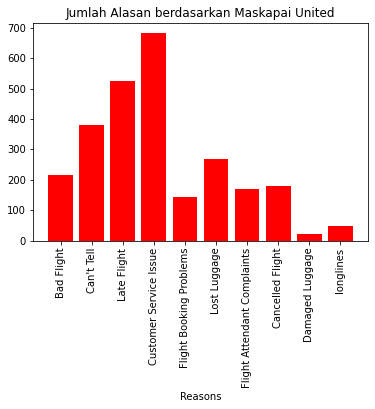

In [16]:
plot_reason('United')

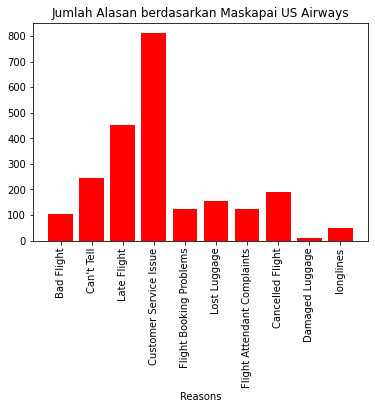

In [17]:
plot_reason('US Airways')

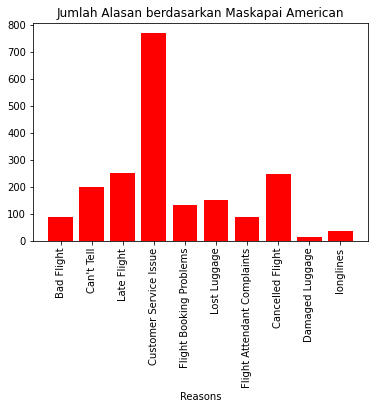

In [18]:
plot_reason('American')

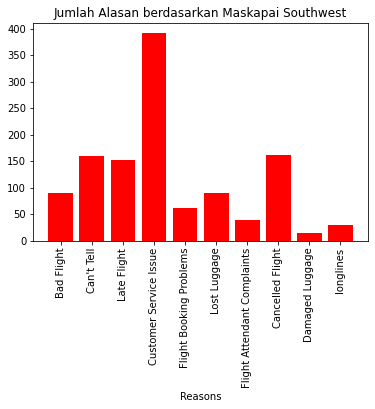

In [19]:
plot_reason('Southwest')

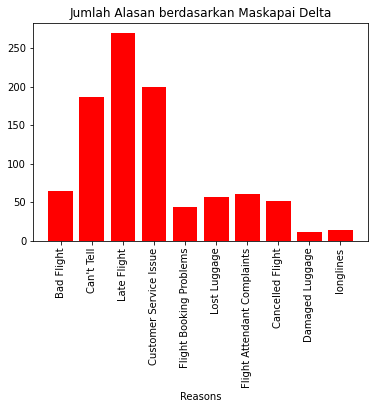

In [20]:
plot_reason('Delta')

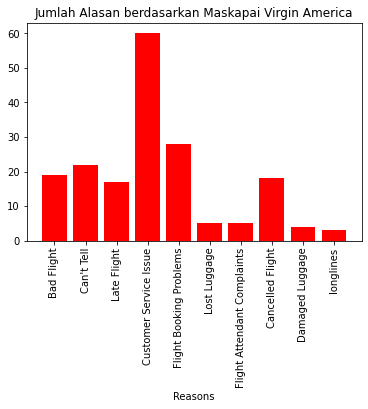

In [21]:
plot_reason('Virgin America')

#### **Melihat Word Cloud untuk sentiment negatif**

In [22]:
from wordcloud import WordCloud, STOPWORDS

In [23]:
df = tweet[tweet['airline_sentiment'] == 'negative']
words = ' '.join(df['text'])
cleaned_word = ' '.join([word for word in words.split()
                          if 'http' not in word
                         and not word.startswith('@')
                         and word != 'RT'])

In [24]:
wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color = 'black',
                      width=3000,
                      height=2500
                      ).generate(cleaned_word)

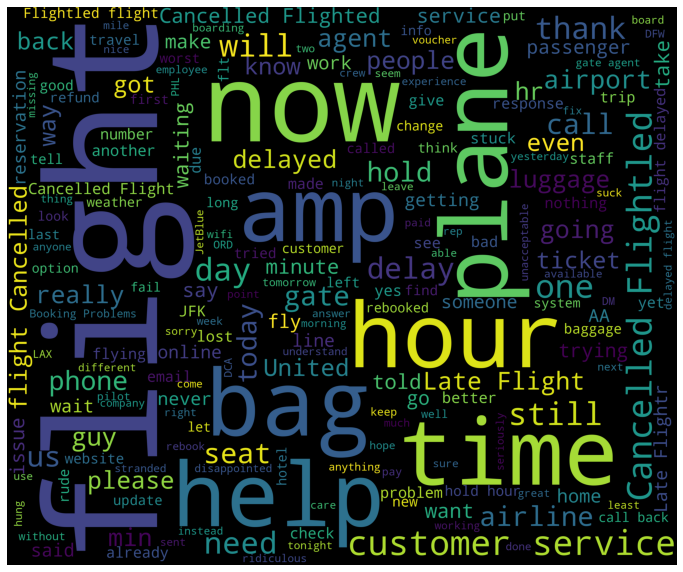

In [25]:
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Kita dapat melihat bahwa tweet-tweet dengan mood negatif kebanyakan diawali dengan kata-kata 'flight', 'plane', 'hour', 'bag', 'help'

#### **Data Preprocessing**

In [26]:
import re
import nltk
from nltk.corpus import stopwords

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Cek stopwords untuk teks berbahasa inggris

In [28]:
print(list(stopwords.words('english')))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Membersihkan tweet dari karakter dan kata-kata yang tidak penting

In [29]:
def clean_words(raw_tweet):
  hanya_huruf = re.sub('[^a-zA-Z]', ' ', raw_tweet)
  katakata = hanya_huruf.lower().split()
  stops = set(stopwords.words('english'))
  katakata_penting = [w for w in katakata if not w in stops]
  return(' '.join(katakata_penting))

In [30]:
def clean_words_length(raw_tweet):
  hanya_huruf = re.sub('[^a-zA-Z]', ' ', raw_tweet)
  katakata = hanya_huruf.lower().split()
  stops = set(stopwords.words('english'))
  katakata_penting = [w for w in katakata if not w in stops]
  return(len(katakata_penting))

In [31]:
tweet['sentimen'] = tweet['airline_sentiment'].apply(lambda x: 0 if x == 'negative' else 1)

In [32]:
tweet['clean_tweet'] = tweet['text'].apply(lambda x: clean_words(x))
tweet['clean_tweet_length'] = tweet['text'].apply(lambda x: clean_words_length(x))

In [33]:
tweet[['airline_sentiment', 'sentimen', 'text', 'clean_tweet', 'clean_tweet_length']].head()

,airline_sentiment,sentimen,text,clean_tweet,clean_tweet_length
0,neutral,1,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said,3
1,positive,1,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...,6
2,neutral,1,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...,8
3,negative,0,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...,11
4,negative,0,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing,5


#### **Data Splitting**

In [34]:
train, test = train_test_split(tweet, test_size=0.2, random_state=42)

In [35]:
print(train.shape)
print(test.shape)

(11712, 15)
(2928, 15)


In [36]:
train_clean_words = []
for tweet in train['clean_tweet']:
  train_clean_words.append(tweet)

test_clean_words = []
for tweet in test['clean_tweet']:
  test_clean_words.append(tweet)

### **Data Training & Testing**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  

#### Count Vectorizer

In [38]:
cv = CountVectorizer(analyzer='word')
train_features = cv.fit_transform(train_clean_words)
test_features = cv.transform(test_clean_words)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

In [40]:
Classifiers = [
    LogisticRegression(C=0.000000001, solver='liblinear', max_iter=200),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel='rbf', C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()
]

In [41]:
dense_training_features = train_features.toarray()
dense_testing_features = test_features.toarray() 

In [42]:
Accuracy = []
Model = []
for classifier in Classifiers:
  try :
    fit = classifier.fit(train_features, train['sentimen'])
    pred = fit.predict(test_features)
  except Exception:
    fit = classifier.fit(dense_training_features, train['sentimen'])
    pred = fit.predict(dense_testing_features)
  accuracy = accuracy_score(pred, test['sentimen'])
  Accuracy.append(accuracy)
  Model.append(classifier.__class__.__name__)
  print('Accuracy of ' + classifier.__class__.__name__ + ' is ' + str(accuracy))

Accuracy of LogisticRegression is 0.6451502732240437
Accuracy of KNeighborsClassifier is 0.5891393442622951
Accuracy of SVC is 0.744535519125683
Accuracy of DecisionTreeClassifier is 0.7609289617486339
Accuracy of RandomForestClassifier is 0.8114754098360656
Accuracy of AdaBoostClassifier is 0.7855191256830601
Accuracy of GaussianNB is 0.5724043715846995


#### Tf-Idf Vectorizer

In [43]:
tfidf = TfidfVectorizer(ngram_range=(1, 1))
train_features_tfidf = tfidf.fit_transform(train_clean_words)
test_features_tfidf = tfidf.transform(test_clean_words)

In [44]:
Classifiers = [
    LogisticRegression(C=0.000000001, solver='liblinear', max_iter=200),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel='rbf', C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    GaussianNB()
]

In [45]:
dense_training_features_tfidf = train_features_tfidf.toarray()
dense_testing_features_tfidf = test_features_tfidf.toarray()

In [58]:
Accuracy_tfidf = []
Model_tfidf = []
for classifier in Classifiers:
  try :
    fit = classifier.fit(train_features_tfidf, train['sentimen'])
    pred_tfidf = fit.predict(test_features_tfidf)
  except Exception:
    fit = classifier.fit(dense_training_features_tfidf, train['sentimen'])
    pred_tfidf = fit.predict(dense_testing_features_tfidf)
  accuracy = accuracy_score(pred_tfidf, test['sentimen'])
  Accuracy_tfidf.append(accuracy)
  Model_tfidf.append(classifier.__class__.__name__)
  print('Accuracy of ' + classifier.__class__.__name__ + ' is ' + str(accuracy))

Accuracy of LogisticRegression is 0.6451502732240437
Accuracy of KNeighborsClassifier is 0.7295081967213115
Accuracy of SVC is 0.6560792349726776
Accuracy of DecisionTreeClassifier is 0.7260928961748634
Accuracy of RandomForestClassifier is 0.8107923497267759
Accuracy of AdaBoostClassifier is 0.7756147540983607
Accuracy of GaussianNB is 0.5754781420765027


#### Membandingkan performansi dari tiap model

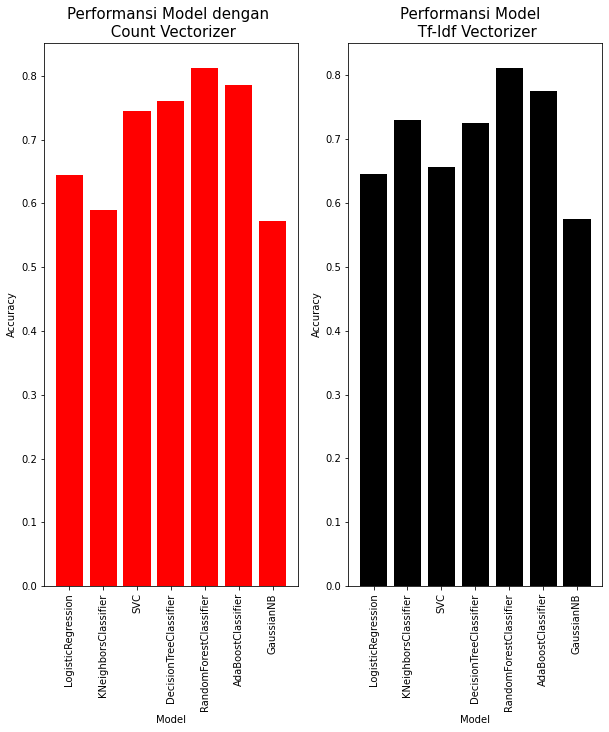

In [59]:
Index = [1, 2, 3, 4, 5, 6, 7]
plt.figure(figsize=(10, 10))

plt.subplot(1,2,1)
plt.bar(Index, Accuracy, color=['red'])
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Performansi Model dengan \n Count Vectorizer', fontsize=15)

plt.subplot(1,2,2)
plt.bar(Index, Accuracy_tfidf, color=['black'])
plt.xticks(Index, Model_tfidf, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Performansi Model  \n Tf-Idf Vectorizer', fontsize=15)

plt.show()

###### Dapat dilihat bahwa baik itu memakai Count Vectorizer ataupun Tf-Idf, model Random Forest tetap memberikan hasil terbaik

In [60]:
print('Nilai Akurasi dengan Random Forest Classifier dengan Count Vectorizer adalah ' + str(Accuracy[4]))
print('Nilai Akurasi dengan Random Forest Classifier dengan Tf-Idf Vectorizer adalah ' + str(Accuracy_tfidf[4]))

Nilai Akurasi dengan Random Forest Classifier dengan Count Vectorizer adalah 0.8114754098360656
Nilai Akurasi dengan Random Forest Classifier dengan Tf-Idf Vectorizer adalah 0.8107923497267759


Nilai akurasi Random Forest dengan Count Vectorizer memberikan nilai yang sedikit lebih baik dibanding dengan Tf-Idf Vectorizer sehinggga kita akan jadikan Random Forest dengan Count Vectorizer sebagai model machine learning untuk dataset ini



In [85]:
random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(train_features, train['sentimen'])
predict_random_forest = random_forest.predict(test_features)

In [92]:
print('Model Accuracy for Random Forest Classifier Using Count Vectorizer :', accuracy_score(test['sentimen'], predict_random_forest))

Model Accuracy for Random Forest Classifier Using Count Vectorizer : 0.8155737704918032


Berikutnya kita akan melihat outcomenya

In [93]:
test.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,sentimen,clean_tweet,clean_tweet_length
4794,569731104070115329,positive,1.0,NaN,NaN,Southwest,JasmineDT,1,@SouthwestAir you're my early frontrunner for ...,2015-02-22 21:30:54 -0800,Washington D.C.,Eastern Time (US & Canada),1,southwestair early frontrunner best airline os...,6
10480,569263373092823040,negative,1.0,Cancelled Flight,1.000,US Airways,ElizabethFrayer,0,@USAirways how is it that my flt to EWR was Ca...,2015-02-21 14:32:19 -0800,NaN,NaN,0,usairways flt ewr cancelled flightled yet flts...,11
8067,568818669024907264,negative,1.0,Late Flight,0.677,Delta,The_Radifier,0,@JetBlue what is going on with your BDL to DCA...,2015-02-20 09:05:13 -0800,"Arlington, VA",Atlantic Time (Canada),0,jetblue going bdl dca flights yesterday today ...,12


In [94]:
dataset_test = test.copy()
dataset_test = pd.DataFrame(dataset_test)
dataset_test = dataset_test[['text']]
dataset_test = dataset_test.reset_index()
dataset_test.head()

,index,text
0,4794,@SouthwestAir you're my early frontrunner for ...
1,10480,@USAirways how is it that my flt to EWR was Ca...
2,8067,@JetBlue what is going on with your BDL to DCA...
3,8880,@JetBlue do they have to depart from Washingto...
4,8292,@JetBlue I can probably find some of them. Are...


In [95]:
dataset_test = dataset_test.drop(['index'], axis=1)
dataset_test.head()

,text
0,@SouthwestAir you're my early frontrunner for ...
1,@USAirways how is it that my flt to EWR was Ca...
2,@JetBlue what is going on with your BDL to DCA...
3,@JetBlue do they have to depart from Washingto...
4,@JetBlue I can probably find some of them. Are...


In [103]:
test_real_label = test.copy()
test_real_label = pd.DataFrame(test_real_label)
test_real_label = test_real_label[['sentimen']]
test_real_label = test_real_label.reset_index()
test_real_label = test_real_label.drop(['index'], axis=1)
test_real_label['sentimen'] = test_real_label['sentimen'].replace({1 : 'positive', 0 : 'negative'})
test_real_label.head()

,sentimen
0,positive
1,negative
2,negative
3,positive
4,negative


In [104]:
test_predicted_label = predict_random_forest.copy()
test_predicted_label = pd.DataFrame(test_predicted_label)
test_predicted_label.columns = ['predicted_sentiment']
test_predicted_label = test_predicted_label.reset_index()
test_predicted_label = test_predicted_label.drop(['index'], axis=1)
test_predicted_label['predicted_sentiment'] = test_predicted_label['predicted_sentiment'].replace({1: 'positive', 0: 'negative'})
test_predicted_label.head()

,predicted_sentiment
0,positive
1,negative
2,negative
3,positive
4,positive


In [106]:
test_result = pd.concat([dataset_test, test_real_label, test_predicted_label], axis=1)
test_result.head()

,text,sentimen,predicted_sentiment
0,@SouthwestAir you're my early frontrunner for ...,positive,positive
1,@USAirways how is it that my flt to EWR was Ca...,negative,negative
2,@JetBlue what is going on with your BDL to DCA...,negative,negative
3,@JetBlue do they have to depart from Washingto...,positive,positive
4,@JetBlue I can probably find some of them. Are...,negative,positive


Berikut dapat dilihat hasil prediksi klasifikasi sentimen memakai Model Random Forest Classifier yang divectorize dengan Count Vectorizer. Berdasarkan nilai akurasi, sekitar 85% dari hasil real data bisa diprediksi dengan benar memakai model Random Forest ini.